# Regularization for ill-posed problems

Recently I had to reconstruct a solution for the thermal boundary between boiling cryogenic liquid and a steel plate. The temperature of the cryogenic-steel boundary is extremely difficult to measure experimentally since the mere presence of the thermocouples would affect the nucleation of bubbles which in turn affect the heat extraction. Also modeling the boiling phenomena is a great computational challenge which is too great of a topic to undertake for this problem. An easier way would be to perform an experiment and measure the temperature at the bottom of the plate. We can then build a direct numerical model which predicts those temperatures and reconstruct the exposure by iterating the initial guess. In this post I will present the Tikhonov regularization method which is used to solve the ill-posed problem.

## Direct problem

In theory inversing the heat equation sounds great, however, the direct numerical implementation would inevitable lead to an ill-posed problem which we cannot solve. To illustrate lets consider the one dimensional heat transfer problem. We want to reconstruct temperatures $T(x, t=t_{0})$ in the past, based on present-day measurements $T(x, t=t_{1})$. In this model we consider the diffusion problem only without and external heat generation or internal heat generation. The heat equation is then given by the parabolic partial differential equation below.

$$
\frac{\partial T}{\partial t} = u \frac{\partial^{2} T}{\partial x^{2}}
$$

Where $T$ is temperature, $t$ is time, $u$ is a constant to represent the material properties and $x$ is the length dimension. The equation represents the balance of energy between the capacitive term $\partial T/\partial t$ and the diffusion $\partial T^{2}/\partial x^{2}$ i.e. the heat transfered through diffusion is responsible for the temperature change.

Lets impose a periodic boundary condition.

$$
T(x+L, t) = T(x, t)
$$

The heat equation can be solved by a simple finite difference explicit scheme as below.

$$
\frac{\Delta T_{n}}{\Delta t} = u \frac{T_{n-1} - T_{n}}{\Delta x^{2}} - u \frac{T_{n} - T_{n+1}}{\Delta x^{2}}
$$

The equation can be vectorized and we can incorporate the boundary condition in the matrix L to handle the internal and external nodes.

$$
\frac{\Delta T}{\Delta t} = u \frac{L T}{\Delta x^{2}}
$$

The linear combination of the equations can then be rewritten by combining the boundary condition, $L$ and the material properties, $u$ as below.

$$
T_{t+1} = A T_{t}
$$

Explicit schemes have issues with numerical stability and require limiting values of the mesh size, $\Delta x$ and time step, $t$. For those interested, the reason is the we are solving a direct system of equations and we need to allow enough time, $(t)$ for the information to propagate from cell to cell, $(\Delta x)$. The critical relationship is known as the Courant–Friedrichs–Lewy (CFL) condition and we would need to check that it is satisfied.

If we chose the values of the constants the above equation can be solved directly. In fact this is known as the direct problem.

The finite difference method can be conveniently implemented using a Toeplitz matrix to approximate the derivatives. The matrix is build using constant value descending diagonals from left to right. The matrix can be represented as

$$
\begin{bmatrix}
a & b & c & d \\
d & a & b & c \\
c & d & a & b \\
d & c & b & a \\
\end{bmatrix}
$$

Our simple discretization scheme is using forward difference for the time and central difference for the space, so lets implement it.

We will use numpy and scipy for our work.

In [1]:
import scipy.linalg
import numpy as np

The domain is discretised using $n=15$ elements and the time step is $t=2\times 10^{1}$. The Tikhonov regularization temr is given by $w=1\times 10^{-2}$.

In [2]:
n = 40
t = 1e1

We can then apply the boundary condition using the Toeplitz matrix.

In [3]:
A = np.zeros((1, n))
A[0, 0] = -1
A[0, 1] = 0.5
A[0, -1] = 0.5
L = scipy.linalg.toeplitz(A)

Let us check the CFL condition for our chosen constants.

In [4]:
t/n < 1

True

all seems okay, we can then calculate the matrix $A$.

In [5]:
A = scipy.linalg.fractional_matrix_power(np.eye(n) + L, t)

The initial condition is then set to provide us with a problem that is interesting to recover.

In [6]:
x = np.arange(0, n)
Tt = np.sin(3*np.pi * x / n)

We can then calculate the direct problem $T_{t+1} = A T_{t}$.

In [7]:
Tfwd = np.dot(A, Tt)
Tfwd

array([ 0.48258534,  0.52670091,  0.54171091,  0.62253495,  0.66895761,
        0.73312732,  0.75678431,  0.75913893,  0.71954341,  0.64474529,
        0.53431844,  0.39482101,  0.23350572,  0.05928686, -0.1182082 ,
       -0.28917105, -0.44415427, -0.57459345, -0.67328051, -0.73476198,
       -0.75564038, -0.73476198, -0.67328051, -0.57459345, -0.44415427,
       -0.28917105, -0.1182082 ,  0.05928686,  0.23350572,  0.39482101,
        0.53431844,  0.64474529,  0.71954341,  0.75913893,  0.75678431,
        0.73312732,  0.66895761,  0.62253495,  0.54171091,  0.52670091])

The solution, $T_{t+1}$ is then visualized and it can be seen that, $T_{t}$ has diffused towards the 0 temperature condition.

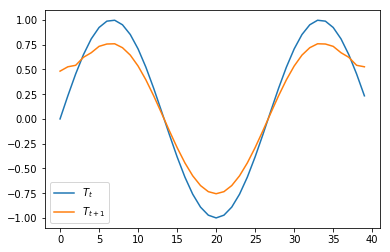

In [8]:
import matplotlib.pyplot as plt

plt.plot(x, Tt, label='$T_{t}$')
plt.plot(x, Tfwd, label='$T_{t+1}$')

plt.legend()
plt.show()

## Inverse problem

The interesting question then becomes: what if we already know the values of $T_{t+1}$ and want to find what $T_{t}$ was? Such a case can be that we have measured the temperature and we are trying to figure out what the temperature used to be before. Naively we can try to inverse the matrix $A$.

$$
T_{t} = A^{-1} T_{t+1}
$$

In [9]:
Tinv = np.dot(np.linalg.inv(A), Tfwd)
Tinv

array([ 6.800e+01, -2.000e+00, -3.560e+02, -4.000e+00,  9.160e+02,
        3.000e+01, -1.632e+03, -2.200e+01,  2.192e+03, -2.400e+01,
       -2.288e+03,  9.600e+01,  1.920e+03, -1.880e+02, -1.304e+03,
        2.540e+02,  7.400e+02, -2.680e+02, -3.680e+02,  2.120e+02,
        1.680e+02, -1.280e+02, -7.200e+01,  5.200e+01,  1.600e+01,
       -1.600e+01,  8.000e+00, -2.000e+00, -1.600e+01,  0.000e+00,
        4.000e+00,  0.000e+00, -4.000e+00,  6.000e+00, -1.200e+01,
       -2.000e+00,  8.000e+00,  4.000e+00, -8.000e+00,  0.000e+00])

We have obtained the inverse matrix. Lets check if we can recover the identity matrix, $I$, even though in this case a visual inspection tells me that something is not right. We are expecting to obtain the equation below.

$$
A^{-1}A = I
$$

We will see that for our case we would not be able to recover it which means that our inversion did not work satisfactory. In other words during the inversion the condition number of the matrix $A$ is so large that the rounding errors are amplified to the point where the errors dominate the solution.

In [10]:
np.allclose(np.dot(A, np.linalg.inv(A)), np.eye(n))

False

As expected our matrix is ill-conditioned and direct inversion did not provide satisfactory results. Lets check the condition number.

In [11]:
np.linalg.cond(A)

3.249636913192119e+16

This is a huge number! The problem arises if the condition number is greater than the machine precision.

In [12]:
np.linalg.cond(A) > np.finfo(A.dtype).eps

True

It seems that this is a wrong approach to use. The condition number is orders of magnitude larger and the errors speak for themselves. In the plot below we are expecting $T_{t}$ and $T_{inv}$ to match.

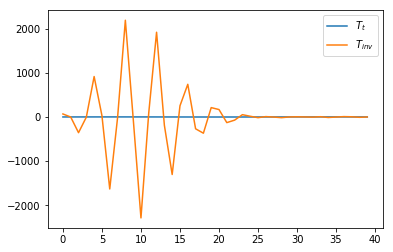

In [13]:
plt.plot(x, Tt, label='$T_{t}$')
plt.plot(x, Tinv, label='$T_{inv}$')

plt.legend()
plt.show()

We have clearly not been able to recover $T_{t}$ from the naive method of inversion.

## Tikhonov Regularization

Tikhonov regularization, with small modification known as Ridge regression in statistics or Weight decay in machine learning can solve the problem by imposing a penalty term $\lambda$. Such problems can be formulated as

$$
\begin{align}
    \text{Minimize } & ||A T_{t} - T_{fwd}||_{2}^{2} + \lambda ||LT_{t}||^{2}_{2} \\
    \text{Subject to } & A \geq 0
\end{align}
$$

This can be done using a linear least squares solver by $lstsq(B, C)$ where we can implement the Tikhonov regularization in the arguments. For reference, the least squares solver expects problems of the type below.

$$
\text{Minimize } ||AT_{t} - T_{fwd}||_{2}^{2}
$$

The arguments been to be modified as such:

$$
B = \begin{bmatrix}
    A\\
    \lambda L
    \end{bmatrix}
$$

And

$$
C = \begin{bmatrix}
    T_{fwd}\\
    L \times 0\\
    \end{bmatrix}
$$

We also need a function to calculate the $R^{2}$ of the fit.

In [14]:
from scipy.stats import linregress

def rsqr(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return r_value**2

The problem can then be solved.

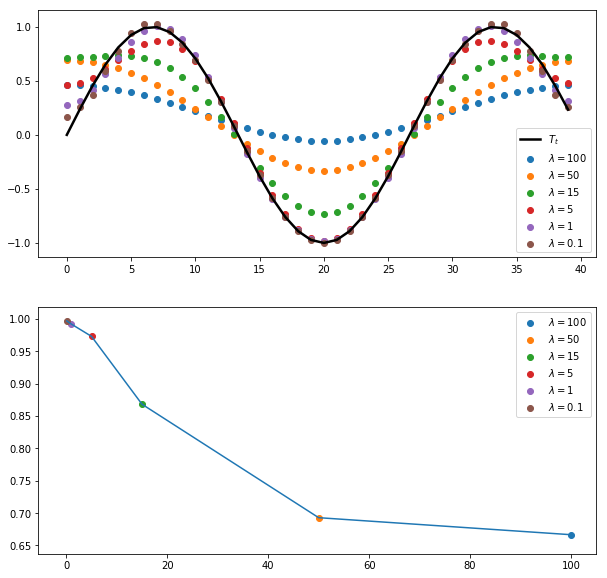

In [15]:
classifiers = [100, 50, 15, 5, 1, 0.1]
r_squared = []

C = np.concatenate([Tfwd, np.zeros(n)])

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
for tikhonov in classifiers:
    B = np.concatenate([A, tikhonov*L])
    T_lstqs =  np.linalg.lstsq(B, C, rcond=None)
    ax[0].scatter(x, T_lstqs[0], label="$\lambda=$" + str(tikhonov))
    
    r_squared.append(rsqr(Tt, T_lstqs[0]))
    ax[1].scatter(tikhonov, r_squared[-1], label="$\lambda=$" + str(tikhonov))

ax[0].plot(x, Tt, label='$T_{t}$', linewidth=2.5, color='black')
ax[0].legend()

ax[1].plot(classifiers, r_squared)
ax[1].legend()
plt.show()

We can see that the results converge towards $T_{t}$ as $\lim_{\lambda \to 0} T(\lambda)$.

## lstsq Solution

For completeness I want to show that we can straight up use $lstsq$ to solve the problem without going in any detail about regularization. However, in doing this we don't learn anything new and we will see in further posts that Tikhonov regularization is indeed needed for solving the bigger optimization problem which is the temperature recovery through the thickness of the specimen to obtain the surface temperature.

In [16]:
Tls = np.linalg.lstsq(A, Tfwd, rcond=None)

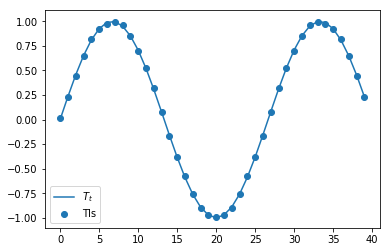

In [17]:
plt.scatter(x, Tls[0], label='Tls')
plt.plot(x, Tt, label='$T_{t}$')
plt.legend()
plt.show()

Which gives a very good fit!

In [18]:
rsqr(Tt, Tls[0])

0.9998417880466148

# Conclusion

We have implemented Tikhonov regularization to solve an ill-conditioned inverse problem. Now we can recover temperatures from previous time steps by only using the current results. Stay tuned for the next posts where I will implement the above solution technique to recover temperatures on the exposed surface by readings from thermocouples located in the depth.